<a href="https://colab.research.google.com/github/Samir-atra/Expenses_tracker/blob/main/project/utils/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
import IPython
import sys
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# data_dir = pathlib.Path('/content/drive/MyDrive/expenses_tracker_classifier/Tobacco3482-jpg/')

def load_data(datadir):
    img_data_array = []
    class_name = []
    class_num = 0

    for dir1 in os.listdir(datadir):
        for file in os.listdir(os.path.join(datadir, dir1)):
            image_path = os.path.join(datadir, dir1, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            if image is None:
                continue
            image = cv2.resize(image, (300, 300))
            image = np.array(image)
            image = image.astype("float32")
            image /= 255
            if len(image.shape) < 3:
                continue
            else:
                img_data_array.append(image)
                class_name.append(class_num)
        class_num +=1
    return img_data_array, class_name




# Split data into training and testing sets
# img_data_array, class_name = load_data(data_dir)
# labels = tf.keras.utils.to_categorical(class_name)
# x_train, x_test, y_train, y_test = train_test_split(np.array(img_data_array), np.array(class_name), test_size=0.3)


# data_path_test = pathlib.Path('/content/drive/MyDrive/archiveX3/Testing/')
# AUTOTUNE=tf.data.AUTOTUNE

# dataset_path = tf.keras.utils.image_dataset_from_directory(        # Training dataset
#     data_path,
#     labels= 'inferred',
#     validation_split=0.2,
#     subset='training',
#     seed= 1,
#     batch_size=5,
#     image_size=(299, 299),
#     color_mode="rgb",
#     shuffle=True)#.cache().prefetch(buffer_size=AUTOTUNE)

# dataset_path_val = tf.keras.utils.image_dataset_from_directory(      #Validation dataset
#     data_path,
#     labels= 'inferred',
#     validation_split=0.2,
#     subset='validation',
#     seed= 2,
#     batch_size=5,
#     image_size=(299, 299),
#     color_mode="rgb",
#     shuffle=True)#.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (300, 300, 3),
    include_top = False,
    weights = "imagenet"
)

In [ ]:
saving_path = pathlib.Path('/content/drive/MyDrive/expenses_tracker_classifier/expenses_tracker_classifier95%test.h5')

base_model.save(saving_path)

In [ ]:
model_path = pathlib.Path('/content/drive/MyDrive/expenses_tracker_classifier/expenses_tracker_classifier95%test.h5')

base_model = tf.keras.models.load_model(model_path)                 #Loading base_model

base_model.trainable = False                                        # Setting the model as non-trainable

rescaling = tf.keras.Sequential([
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)             # Rescaling to (1, -1) range required for inceptionV3 model
])
augmentation = tf.keras.Sequential([                                # Applying augmentations o the images
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.1)
])


inputs = tf.keras.Input(shape=(300, 300, 3))
x = augmentation(inputs)
x = rescaling(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)                   # "softmax" in the final layer for decision making
model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),        # compiling with low learning rate
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly = True)

model.fit(                                                               # fitting the whole model for non-trainable base
    x_train,
    y_train,
    epochs=30,)

model.evaluate(
    x=x_test,
    y=y_test,)


this is iamges 1 [1]


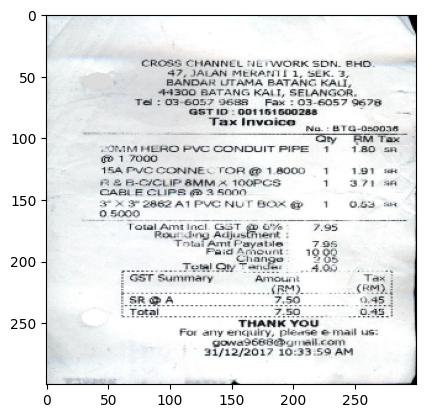

<class 'numpy.ndarray'>


1/1 [==============================] - 1s 1s/step
beedoo
this is pred [0 0 0 ... 7 7 4]


In [47]:
loading_path = pathlib.Path('/content/drive/MyDrive/expenses_tracker_classifier/expenses_tracker_classifier95%test.h5')
loaded_model = tf.keras.models.load_model(loading_path, compile=True)
pred_img_path = pathlib.Path('/content/drive/MyDrive/expenses_tracker_classifier/pred_imgs/')
images, labels = load_data(pred_img_path)
print("this is iamges", len(labels), labels)
# print("this is labels", labels)

# loaded_model.compile(
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),        # compiling with low learning rate
#     loss=tf.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy'],
#     run_eagerly = True)

for image in images:
  #  for i in range(1):
      #  ax = plt.subplot(1, 1, i+1)
   plt.imshow(images[0].astype("float32"))
      #  plt.title(class_names[labels[i]])
      #  plt.axis("off")
   plt.show()


sample_list = []                                                        # creating a list of sample(s)
for sample in images:
    sample_list.append(sample)
    continue

sample_list = np.array(sample_list)                                     # converting the sample list to numpy array
for sample in sample_list:
    print(type(sample_list[0]))
    images[0] = tf.expand_dims(images[0], axis=0)
    predictions = loaded_model.predict(images[0])
    pred = np.argmax(predictions, axis=1)
    print("beedoo")                                              # loop for predicting and showing result for sample image(s)
    print("this is pred", pred)